In this project, we will explore how to implement image classification using machine learning. It demonstrates the implementation of Image Segmentation by using K-Mean Clustering. The dataset is available in kaggle https://www.kaggle.com/datasets/tongpython/cat-and-dog

**Import nessessary library**

In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

**Data Preprocessing**

In [3]:
# Function to preprocess images
def preprocess_image(image_path, target_size=(128, 128)):
    img = Image.open(image_path).convert('RGB')  # Convert to grayscale
    img = img.resize(target_size)             # Resize to target size
    img_array = np.array(img)                 # Convert to numpy array
    return img_array / 255.0        # Normalize and flatte

This function is designed for preprocessing an input image. It performs several key operations. First, the image is read into the program, and then it is resized to the desired dimensions. Next, the image is converted into a numpy array format, which is essential for numerical operations in Python. Finally, the values in the array are normalized to a range between 0 and 1, which is a common practice in image processing to ensure uniformity and better performance during analysis or training.

**Load Dataset**

In [4]:
def load_dataset(data_dir, categories, target_size=(128, 128), test_size=0.2, random_state=42):
    
    images, labels = [], []  # Initialize empty lists to store image data and labels
    valid_extensions = ('.png', '.jpg', '.jpeg')  # Define valid image file extensions

    for category in categories:
        category_dir = os.path.join(data_dir, category)  # Construct the path to the category directory
        for file_name in os.listdir(category_dir):
            # Skip hidden/system files or files with invalid extensions
            if file_name.startswith('.') or not file_name.lower().endswith(valid_extensions):
                continue
            
            file_path = os.path.join(category_dir, file_name)  # Construct the full path to the file
            try:
                # Preprocess the image
                img_array = preprocess_image(file_path, target_size)
                images.append(img_array)  # Add processed image to the list
                labels.append(category)  # Add category label
            except Exception as e:
                print(f"Error loading image {file_path}: {e}")

    # Convert lists to NumPy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        images, labels, test_size=test_size, random_state=random_state, stratify=labels
    )
    
    return X_train, X_test, y_train, y_test

Loading a dataset is a crucial step in data preparation, particularly for deep learning tasks. In this case, the data consists of images, and its structure plays a significant role in the processing pipeline. The primary goal of this function is to transform raw images into a standardized format of [batch, width, height, channel], which aligns with the conventions used in PyTorch. By doing so, it enables batch training, a standard practice in most popular deep learning frameworks, ensuring efficiency and scalability during the training process.

In [9]:
# Note that the path will be different on your environment.

training_path = "./archive/training_set/training_set/"


categories = ['cats','dogs']

# Load and split the dataset
X_train, X_test, y_train, y_test = load_dataset(training_path, categories, target_size=(128, 128), test_size=0.2)

# Check the shapes of the resulting arrays
print("Training set:", X_train.shape, y_train.shape)
print("Testing set:", X_test.shape, y_test.shape)

Training set: (6404, 128, 128, 3) (6404,)
Testing set: (1601, 128, 128, 3) (1601,)


In [10]:
# Checking labels
y_train[4000]

'cats'

**Simple Visualization**

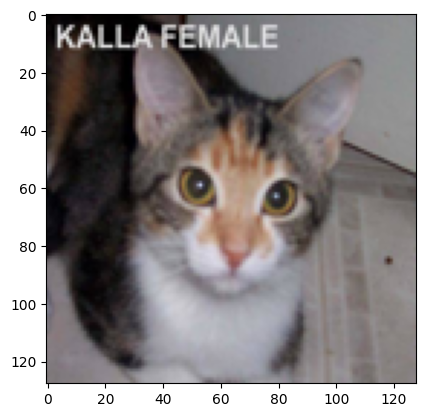

In [11]:
img_ex = X_train[4000,:,:,:] # Select the 4000th image to visualize
plt.imshow(img_ex)
plt.show()

pixels shape : (1638400, 3)
K-means converged in 15 iterations.


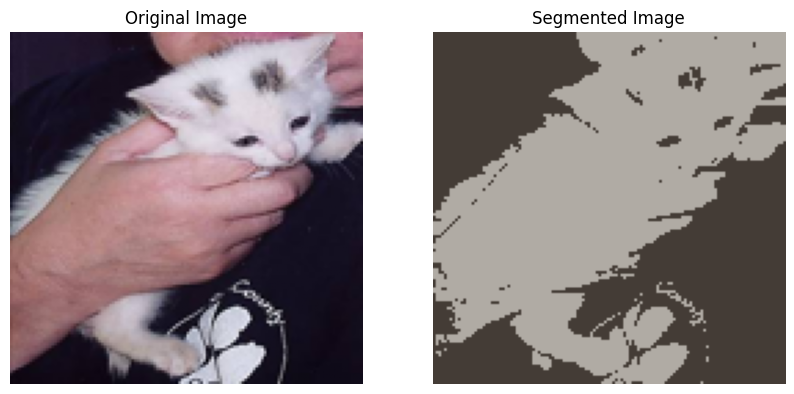

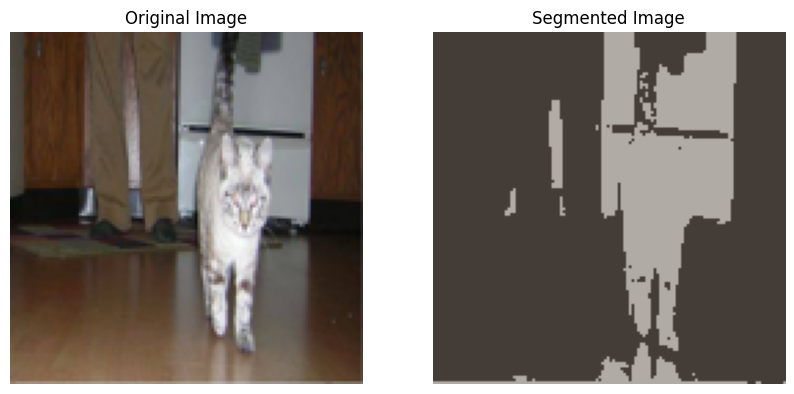

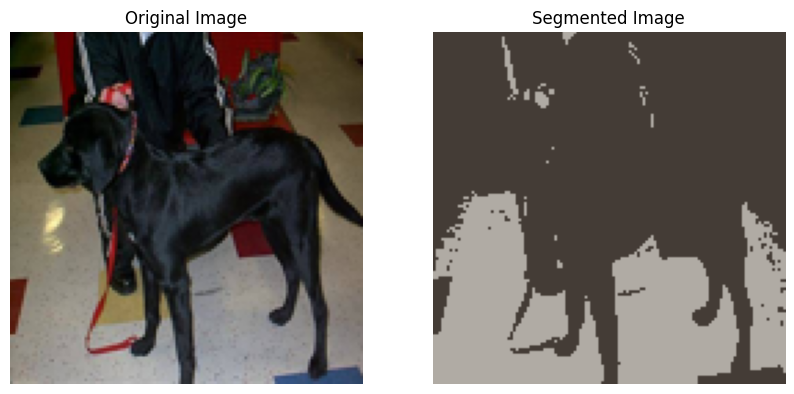

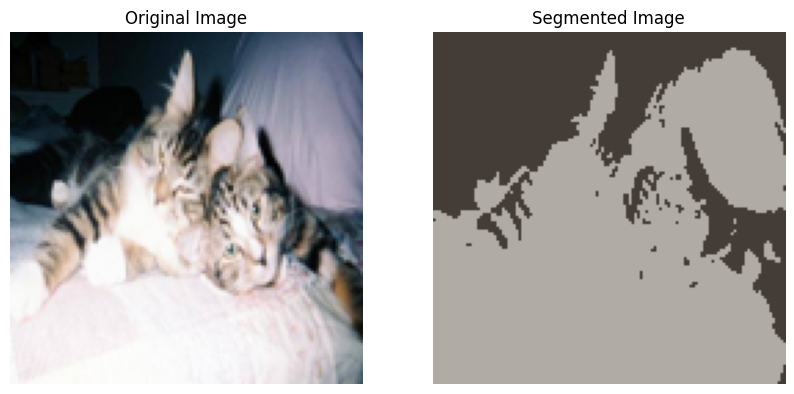

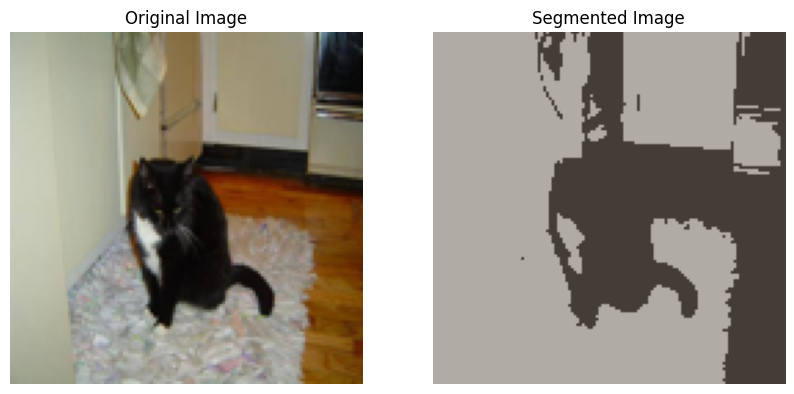

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from PIL import Image
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


X_example = X_train[:100]

# Function to perform K-means clustering for segmentation
# Implement K-means from scratch for multiple images
def kmeans_segmentation_dataset(images, n_clusters, max_iter=50):
    """Perform K-means clustering for a dataset of images."""
    n_samples, rows, cols, channels = images.shape
    pixels = images.reshape((-1, channels))  # Flatten all images into (total_pixels, num_features)

    print(f'pixels shape : {pixels.shape}')

    # Randomly initialize cluster centers
    rng = np.random.RandomState(42)
    random_indices = rng.permutation(pixels.shape[0])[:n_clusters]
    centers = pixels[random_indices]

    for iteration in range(max_iter):
        # Step 1: Assign labels based on closest center
        labels = pairwise_distances_argmin(pixels, centers)

        # Step 2: Recalculate centers
        new_centers = np.array([pixels[labels == i].mean(axis=0) for i in range(n_clusters)])

        # Step 3: Check for convergence
        # It checks whether the absolute difference between the corresponding elements of centers and new_centers is less than or equal to: 1e-6 x |new_senters|
        if np.allclose(centers, new_centers, rtol=1e-10):
            print(f"K-means converged in {iteration} iterations.")
            break

        centers = new_centers

    # Assign each pixel to its cluster's centroid
    segmented_pixels = centers[labels]
    segmented_images = segmented_pixels.reshape((n_samples, rows, cols, channels))
    return segmented_images

# Perform K-means segmentation on the dataset
n_clusters = 2  # Number of clusters
segmented_images = kmeans_segmentation_dataset(X_example, n_clusters)

# Display original and segmented images for the first few samples
for i in range(min(5, len(X_train))):  # Display up to 5 images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(X_train[i])
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Segmented Image")
    plt.imshow(segmented_images[i])
    plt.axis("off")
    plt.show()

The provided code defines a function kmeans_segmentation_dataset that performs K-means clustering for a dataset of images. The function takes in an array of images, the number of clusters (n_clusters), and a maximum number of iterations (max_iter). Each image in the dataset is flattened into a list of pixel features, combining all images into a single dataset of pixel values. The K-means algorithm initializes cluster centers randomly and iteratively refines them. In each iteration, pixels are assigned to the closest cluster center, and new cluster centers are computed as the mean of all pixels in each cluster. The algorithm checks for convergence by comparing the old and new cluster centers using np.allclose, stopping if the centers have stabilized within a relative tolerance of 1e-6. Once convergence is achieved or the maximum number of iterations is reached, the function reconstructs the segmented images by mapping each pixel to its corresponding cluster center. The result is a set of images segmented into the specified number of clusters, which is useful for image segmentation tasks. In the example usage, the function is called with n_clusters=2 to segment the dataset X_train into two clusters.